### Решение судоку

In [35]:
# Поиск первой нерешенной ячейки
def find_first_empty(table):
    # в лоб обходим всю таблицу
    for i in range(len(table)):
        for j in range(len(table[0])):
            if table[i][j] == 0:
                return (i, j)  # row, col
    # если все ячейки заполнены - возвращает None
    return None

# Проверка, можно ли вставить данную цифру на текущую позицию
def check_if_valid(table, digit, position):
    # сначала проверка по строке
    for i in range(len(table[0])):
        # если такая цифра уже встречается, то вставить ее нельзя
        if table[position[0]][i] == digit and position[1] != i:
            return False
    # проверка по столбцу
    for i in range(len(table)):
        if table[i][position[1]] == digit and position[0] != i:
            return False
    # проверка по одной из девяти клеток таблицы
    box_x, box_y = (position[1] // 3), (position[0] // 3)
    # обходим клетку
    for i in range(box_y * 3, box_y * 3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            # если цифра встретилась на другом месте, то ее нельзя вставить
            if table[i][j] == digit and (i,j) != position:
                return False
    # если все проверки пройдены, цифру можно вставить
    return True


def try_to_solve(table):
    # ищем первую пустую клетку
    empty_cell = find_first_empty(table)
    # если пустых клеток больше нет, то таблица решена
    if not empty_cell:
        return True
    else:
        # иначе запоминаем координаты пустой клетки
        row, col = empty_cell
    # последовательно пытаемся вставить числа от 1 до 9
    for i in range(1,10):
        # если можно вставить - вставляем
        if check_if_valid(table, i, (row, col)):
            table[row][col] = i
            # рекурсивно решаем следующую клетку
            if try_to_solve(table):
                return True
            # иначе вставляем в данную ячейку ноль
            table[row][col] = 0
    # если цикл был пройден, но встален 0 - значит, решения нет
    return False

# главная функция, запускающая остальные
def get_solved_table(table):
    # если получилось решить - возвращаем решенную таблицу
    if try_to_solve(table):
        return table
    else:
        # иначе поднимаем ошибку
        raise ValueError




## Детекция таблицы на изображении

Необходимые библиотеки

In [36]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
import matplotlib.pyplot as plt

Загрузка предобученной модели распознавания чисел и информации для нее

In [37]:
# числа 1-9 - классы для работы модели
classes = np.arange(0, 10)
# модели распознавания чисел
model = load_model('model.h5')
# print(model.summary())
# размер изображения для загрузки в модель
input_size = 48

Функция, опеределяющая таблицу судоку на изображении. Возвращает кадированное изображение без перспективы размера 900х900, чтобы удобнее было делить в дальшейшем на ячейки 100х100

In [38]:
def get_perspective_image(img, location):
    height, width = 900, 900
    # координаты исходного положения
    source = np.float32([location[0], location[3], location[1], location[2]])
    # требуемого положение
    destination = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    # получение матрицы преобразования
    matrix = cv2.getPerspectiveTransform(source, destination)
    # применение матрицы преобразования
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

Функция поиска таблицы на изображении

In [39]:
def find_table(img):
    # уменьшение шума и сглаживание на изображении в оттенках серого
    bfilter = cv2.bilateralFilter(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 13, 20, 20)

    # определение краев изображения
    edges = cv2.Canny(bfilter, 30, 180)
    # поиск контуров на изображении
    contours = imutils.grab_contours(cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE))
    # отрисовка контуров
    contered_image = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    plt.imshow(contered_image)

    # возвращает 10 самых длинных контуров
    # предполагается, что среди них будет таблица судоку
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # будет хранить положение таблицы на изображении
    location = None
    
    # поиск контура, который после аппроксимации может представлять собой квадрат
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break

    # result - вырезанная таблица из изображения
    result = get_perspective_image(img, location)
    return result, location

Пример работы функции поиска таблицы



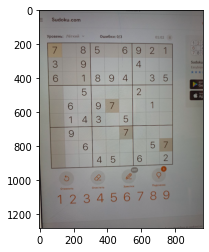

In [40]:
# Изначальное изображение
img = cv2.imread('sudoku_test.jpg')
plt.imshow(img)


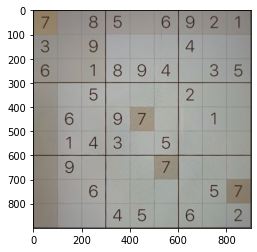

In [41]:
# изображение таблицы
result, location = find_table(img)
plt.imshow(result)

Функция, возвращающая 81 ячейку, извлеченную из полученной таблицы

In [42]:
def split_to_cells(board):
    # вертикальное разделение на 9 подмассивов
    rows = np.vsplit(board,9)
    # ячейки
    cells = []
    for r in rows:
        # горизонтальное разделение на 9 ячеек
        cols = np.hsplit(r,9)
        # трансформация каждого изображения для загрузки в модель
        for cell in cols:
            cell = cv2.resize(cell, (input_size, input_size))/255.0
            cells.append(cell)
    return cells

Посмотрим результат работы на предыдущих даных - одна из вырезанных ячеек (левая верхняя)

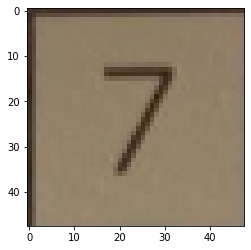

In [43]:
cells = split_to_cells(result)
plt.imshow(cells[0])

Функция определения цифр на изображении

In [44]:
def detect_digits(cells):
  # изменения размера изображения для определения числа с помощью модели
  cells = np.array(cells).reshape(-1, input_size, input_size, 1)
  # предсказание чисел - то есть определение цифр на соответствующих изображениях
  prediction = model.predict(cells)

  # так как в предыдущем шаге получили вероятности цифр,
  # то теперь с помощью вероятностей нужно извлечь цифры
  predicted_digits = []
  for i in prediction: 
    # получение индекса максимального элемента - самой вероятной цифры
    index = (np.argmax(i))
    # получение класса цифры
    predicted_number = classes[index]
    # добавление в массив
    # если был добавлен 0 - ячейка пуста
    predicted_digits.append(predicted_number)
  table_digits = np.array(predicted_digits).astype('uint8').reshape(9, 9)
  return table_digits, predicted_digits


Функция поиска цифр, которые нужно будет отрисовать на изображении

In [45]:
def create_mask_for_empty_cells(predicted_digits, solved_table):
  # создание маски, которая накрывает только изначально пустые ячейки
  # единицы будут стоять только в тех индексах, где была пустота
  binary_mask = np.where(np.array(predicted_digits)>0, 0, 1)
  # накрываем маской решенный массив судоку
  # оставляя только новые вставленные числа
  flatten_solved_table = solved_table.flatten()*binary_mask
  return flatten_solved_table
  

Функция, отрисовывающая цифры на изображении

In [46]:
def displayNumbers(img, numbers):
    color=(255, 216, 0)
    # размер одной ячейки
    width, height = int(img.shape[1]/9), int(img.shape[0]/9)
    # проходим по всему массиву
    for i in range (9):
        for j in range (9):
            # если в эту ячейку нужно поместить цифру
            if numbers[(j*9)+i] !=0:
                # добавляем текст заданного цвета
                cv2.putText(img, str(numbers[(j*9)+i]), (i*width+int(width/2)-int((width/4)), int((j+0.7)*height)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    return img

Функция для отрисовки цифр в перспективе, то есть функция, обратная get_perspective

In [47]:
def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    source = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    destination = np.float32([location[0], location[3], location[1], location[2]])
    matrix = cv2.getPerspectiveTransform(source, destination)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    return result

Основная функция для решения судоку

In [48]:
def solve_image(img_path):
  # загрузка изображения
  img = cv2.imread(img_path)
  # получение кадрированного изображения таблицы судоку
  board, location = find_table(img)
  plt.imshow(board)
  # перевод изображения в оттенки серого
  gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
  
  try:
    # получение 81-го изображения ячейки судоку
    rois = split_to_cells(gray)
    # определение двумерного массива соответствующих чисел на изображении
    table_digits, predicted_digits = detect_digits(rois)
    # решение судоку - заполненный двумерный массив, который нужно отрисовать
    solved_table = get_solved_table(table_digits)
    # создание маски для решенных ячеек
    flatten_solved_table = create_mask_for_empty_cells(predicted_digits, solved_table)
    # создание массива, аналогичного по размерам выразанной таблицы судоку
    # из исходного иображения
    mask = np.zeros_like(board)
    # помещаем решенные ячейки в созданную маску
    solved_board_mask = displayNumbers(mask, flatten_solved_table)
    # обратное преобразование изначальному кадированию -
    # возвращение перспективы таблице
    inv = get_InvPerspective(img, solved_board_mask, location)
    # теперь нужно соединить два изображения - исходное и цифры, 
    # отрисованные на местах пустых ячеек
    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    # вывод полученного изображения
    plt.imshow(combined)
    # сохранение в папку
    cv2.imwrite("output/" + img_path + "_solved.jpg", combined)

  except:
    print("Попробуйте изменить изображение, возможно, немного повернуть.")
    print("Если таблица отображается правильно, но не заполнена - решения данной задачи нет")

## Примеры работы

3/3 [==============================] - 1s 165ms/step


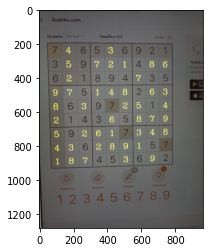

In [49]:
solve_image('sudoku_test.jpg')

3/3 [==============================] - 0s 91ms/step


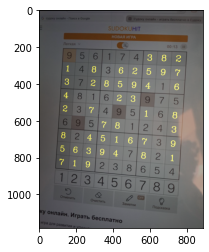

In [50]:
solve_image('sudoku1.jpg')

3/3 [==============================] - 0s 94ms/step


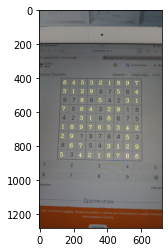

In [51]:
solve_image('sudoku2.jpg')